# Data Exploration: Regression of Used Car Prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

#pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.float_format = '{:,.0f}'.format


In [2]:
# Load the dataset
cars_train_path = 'data/train.csv'
cars_train_df = pd.read_csv(cars_train_path,index_col=None)
cars_train_df.columns= cars_train_df.columns.str.lower()
cars_train_df.columns = cars_train_df.columns.str.replace(' ','_')

In [3]:
cars_train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


## Inital Data Transformation

In [4]:
# Binary variables formatting

#accident and clean title
cars_train_df['vehicle_damage'] = cars_train_df['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})

# Clean title map Yes -> 1 and Blank -> 0
cars_train_df['binary_clean_title'] = cars_train_df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

#categoric, numeric,binary

In [5]:
# Functions to extract different parts associated to the engine

# Extracting HP - Extracts digits before HP, with decimals or with no decimals
def extract_hp(value):
    match = re.search(r'(\d+\.\d+|\d+)HP', value)
    return match.group(1) if match else None
    
# Extracting Engine Size (L) - Extracts digits before L, with decimals or with no decimals
def extract_size(value):
    match = re.search(r'(\d+\.\d+|\d+)L', value)
    return match.group(1) if match else None
    
# Extracting number of cylinders - Extracts digits before Cylinder, with no decimals
def extract_cylinder(value):
    match = re.search(r'(\d+) Cylinder', value)
    return match.group(1) if match else None

def extract_fuel_type(value):
    if 'Hybrid' in value:
        return 'Hybrid'
    elif 'Electric' in value:
        return 'Electric'
    elif 'Gasoline' in value:
        return 'Gasoline'
    elif 'Diesel' in value:
        return 'Diesel'
    else:
        return 'Other'

def extract_engine_config(value):
    if 'V' in value:
        return 'V-Type'
    elif 'I' in value or 'inline' in value:
        return 'Inline'
    elif 'Flat' in value :
        return 'Flat'   
    else:
        return 'Other'
        
def extract_turbo(value):
    # Use re.IGNORECASE for case-insensitive matching
    if re.search(r'turbo', value, re.IGNORECASE):
        return 1
    else:
        return 0

In [6]:
cars_train_df['hp'] = cars_train_df['engine'].apply(extract_hp)
cars_train_df['size'] = cars_train_df['engine'].apply(extract_size)
cars_train_df['cylinder'] = cars_train_df['engine'].apply(extract_cylinder)
cars_train_df['fuel_type_2'] = cars_train_df['engine'].apply(extract_fuel_type)
cars_train_df['engine_config'] = cars_train_df['engine'].apply(extract_engine_config)
cars_train_df['turbo'] = cars_train_df['engine'].apply(extract_turbo)

In [7]:
# Functions to extract transmission type and number of speeds
# Map transmission type
def map_transmission_type(value):
    if 'M/T' in value or 'Manual' in value or 'Mt' in value:
        return 'Manual'
    elif 'A/T' in value or 'Automatic' in value or 'CVT' in value:
        return 'Automatic'
    elif 'CVT' in value:
        return 'CVT'
    elif 'Dual Shift' in value:
        return 'DCT' 
    else: 
        return 'Other'  # For any unexpected values

# Extract number of speeds
def extract_speeds(value):
    # Regular expression to find the speed number
    import re
    match = re.search(r'(\d+)-Speed', value, re.IGNORECASE)
    if match:
        return int(match.group(1))
    elif 'Single-Speed' in value or '1-Speed' in value:
        return 1
    else:
        return None  # If no speed is found


In [8]:
cars_train_df['transmission_type'] = cars_train_df['transmission'].apply(map_transmission_type)
cars_train_df['speed'] = cars_train_df['transmission'].apply(extract_speeds)

In [9]:
cars_train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,vehicle_damage,binary_clean_title,hp,size,cylinder,fuel_type_2,engine_config,turbo,transmission_type,speed
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,0,1,172.0,1.6,4,Gasoline,Other,0,Automatic,NaN
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,1,1,252.0,3.9,8,Gasoline,Other,0,Automatic,NaN
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,0,1,320.0,5.3,8,Other,Other,0,Automatic,NaN
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,0,1,420.0,5.0,8,Gasoline,Other,0,DCT,NaN
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,0,1,208.0,2.0,4,Gasoline,Other,0,Automatic,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,...,0,1,420.0,6.2,8,Gasoline,Other,0,DCT,NaN
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,...,1,1,385.0,3.0,6,Gasoline,V-Type,0,Automatic,8
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,0,1,469.0,4.0,8,Gasoline,Other,0,Automatic,7
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,...,0,0,None,3.0,None,Other,Other,0,Automatic,1


In [10]:
binary_columns = ['vehicle_damage', 'binary_clean_title','turbo']
categorical_columns_low_cardinality = ['fuel_type','fuel_type_2','engine_config', 'transmission_type']
categorical_columns_high_cardinality = ['brand', 'model', 'ext_col', 'int_col']
numeric_columns = ['model_year', 'milage','hp','size']
ordinal_columns = ['cylinder','speed']

In [11]:
cars_train_df[numeric_columns] = cars_train_df[numeric_columns].astype('float64')

## Data exploration - Metrics and Dimensions Separately

### Price

In [12]:
cars_train_df['price'].describe()

count     188,533
mean       43,878
std        78,820
min         2,000
25%        17,000
50%        30,825
75%        49,900
max     2,954,083
Name: price, dtype: float64

In [13]:
price_percentile = cars_train_df['price'].quantile(0.95)
print(price_percentile)

107900.0


In [14]:
filtered_prices = cars_train_df[cars_train_df['price'] <= price_percentile].copy()

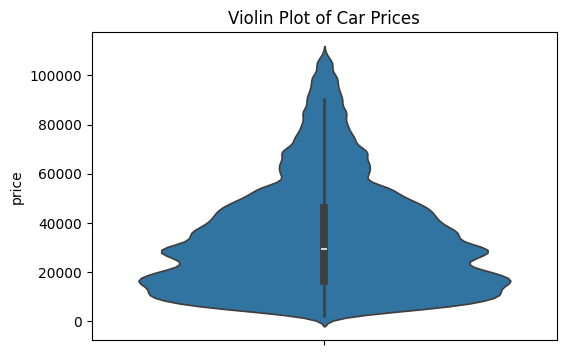

In [15]:
# Set up the figure size
plt.figure(figsize=(6, 4))

# Create a violin plot for the 'price' column
sns.violinplot(y=filtered_prices['price'])

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# title for the plot
plt.title('Violin Plot of Car Prices')

# Show the plot
plt.show()

### Binary Variables

Binary counts for vehicle_damage:
vehicle_damage
0    144514
1     41567
Name: count, dtype: int64


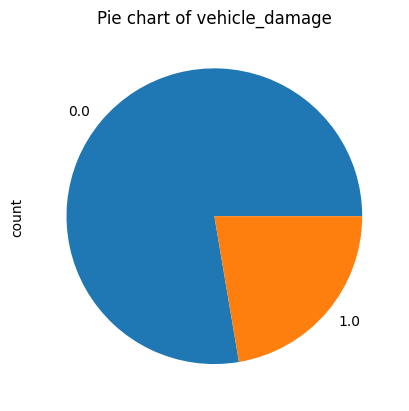

Binary counts for binary_clean_title:
binary_clean_title
1    167114
0     21419
Name: count, dtype: int64


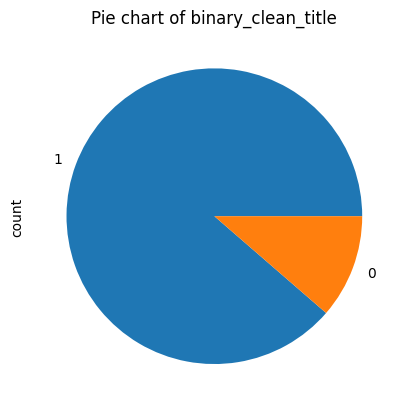

Binary counts for turbo:
turbo
0    174263
1     14270
Name: count, dtype: int64


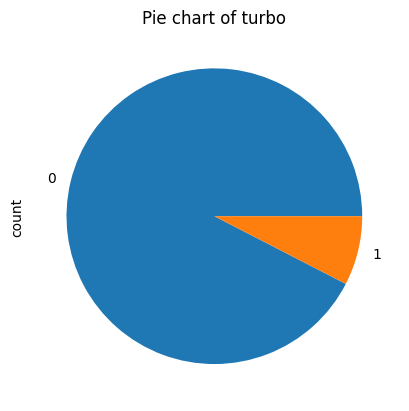

In [16]:
for col in binary_columns:
    print(f"Binary counts for {col}:")
    print(cars_train_df[col].value_counts())
    cars_train_df[col].value_counts().plot(kind='pie')
    plt.title(f'Pie chart of {col}')
    plt.show()

### Metrics - Numeric Variables

Descriptive statistics for model_year:
count   188,533
mean      2,016
std           6
min       1,974
25%       2,013
50%       2,017
75%       2,020
max       2,024
Name: model_year, dtype: float64


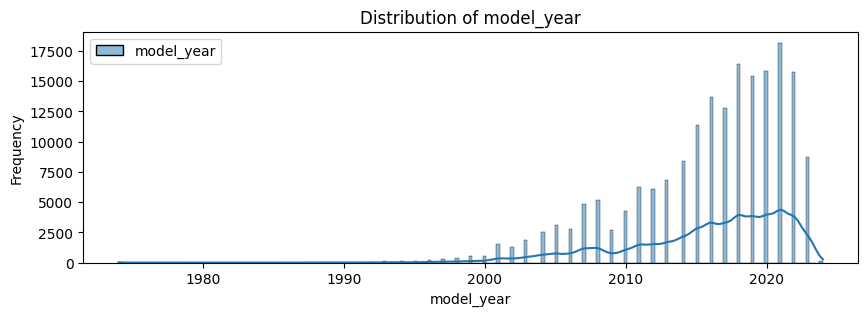

Descriptive statistics for milage:
count   188,533
mean     65,705
std      49,798
min         100
25%      24,115
50%      57,785
75%      95,400
max     405,000
Name: milage, dtype: float64


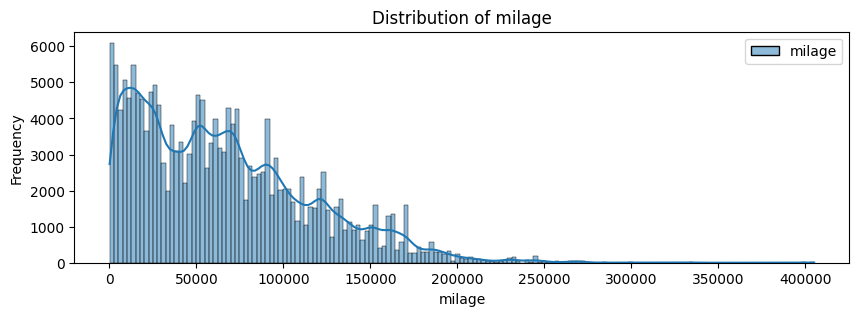

Descriptive statistics for hp:
count   155,274
mean        343
std         115
min          70
25%         263
50%         329
75%         416
max       1,020
Name: hp, dtype: float64


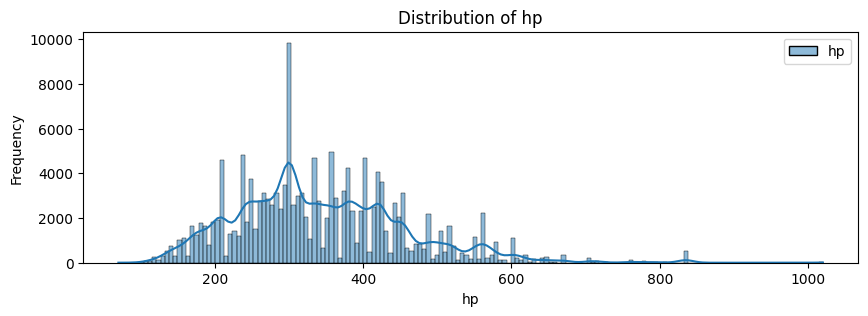

Descriptive statistics for size:
count   174,319
mean          4
std           1
min           1
25%           3
50%           4
75%           5
max           8
Name: size, dtype: float64


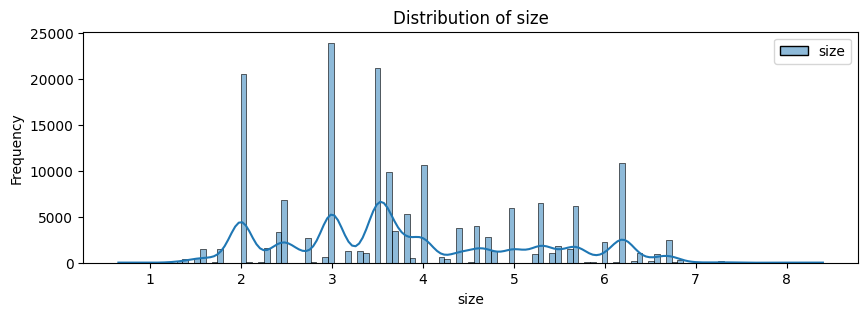

In [17]:
for col in numeric_columns:
    print(f"Descriptive statistics for {col}:")
    print(cars_train_df[col].describe())
    plt.figure(figsize=(10, 3))
    sns.histplot([cars_train_df[col]], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### Ordinal Variables

Descriptive statistics for cylinder:
count     150678
unique         7
top            6
freq       66301
Name: cylinder, dtype: object


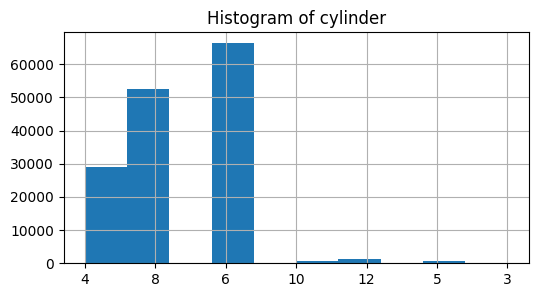

Descriptive statistics for speed:
count   104,115
mean          7
std           2
min           1
25%           6
50%           7
75%           8
max          10
Name: speed, dtype: float64


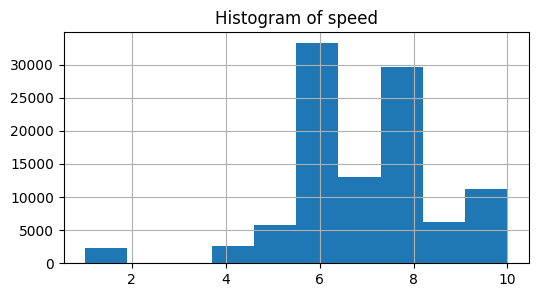

In [18]:
### Ordinal Variables 
for col in ordinal_columns:
    print(f"Descriptive statistics for {col}:")
    print(cars_train_df[col].describe())
    plt.figure(figsize=(6, 3))
    cars_train_df[col].hist()
    plt.title(f'Histogram of {col}')
    plt.show()

### Categorical Columns

Frequency counts for fuel_type:
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


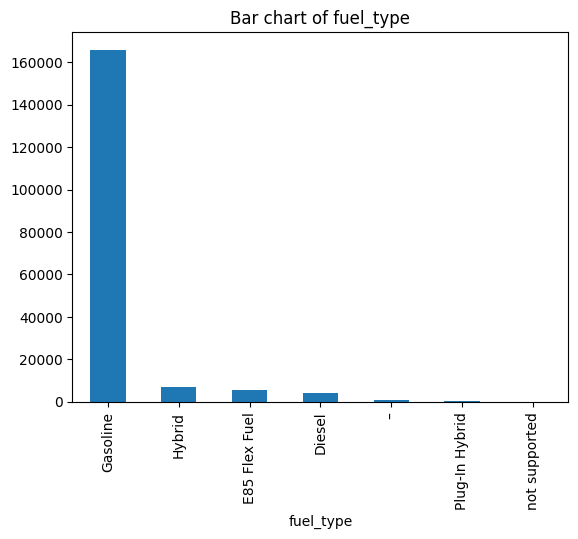

Frequency counts for fuel_type_2:
fuel_type_2
Gasoline    136161
Other        36714
Electric      6008
Hybrid        5531
Diesel        4119
Name: count, dtype: int64


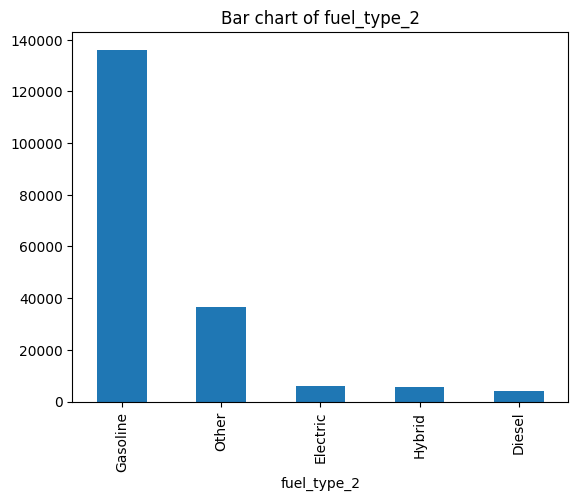

Frequency counts for engine_config:
engine_config
Other     108726
V-Type     72947
Flat        5344
Inline      1516
Name: count, dtype: int64


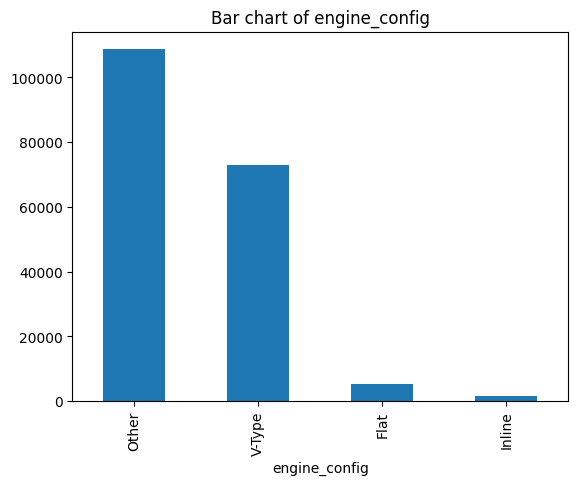

Frequency counts for transmission_type:
transmission_type
Automatic    152307
DCT           19255
Manual        16415
Other           556
Name: count, dtype: int64


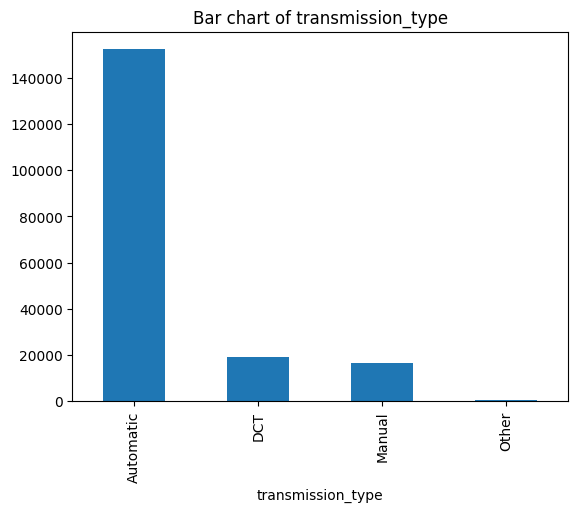

In [19]:
# Categorical Columns
for col in categorical_columns_low_cardinality:
    print(f"Frequency counts for {col}:")
    print(cars_train_df[col].value_counts())
    cars_train_df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar chart of {col}')
    plt.show()

Frequency counts for brand:
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Other            57919
Name: count, dtype: int64


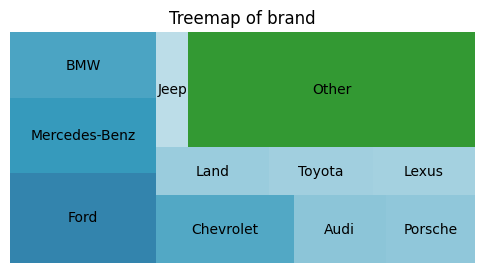

Frequency counts for model:
model
F-150 XLT                 2945
M3 Base                   2229
Camaro 2SS                1709
M4 Base                   1622
Mustang GT Premium        1526
F-150 Lariat              1410
E-Class E 350 4MATIC      1357
1500 Laramie              1249
911 Carrera S             1219
Corvette Base             1184
Other                   172083
Name: count, dtype: int64


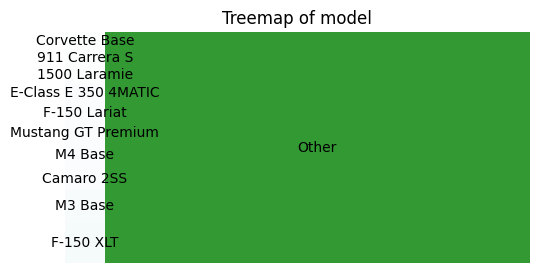

Frequency counts for ext_col:
ext_col
Black     48658
White     43815
Gray      25293
Silver    16995
Blue      14555
Red        9901
Green      2698
Gold       1668
Brown      1162
Orange     1139
Other     22649
Name: count, dtype: int64


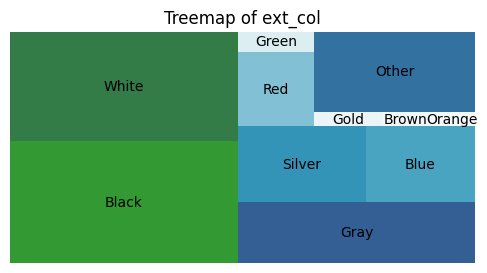

Frequency counts for int_col:
int_col
Black        107674
Beige         24495
Gray          21204
Brown          5810
Red            5145
White          4743
–              4527
Jet Black      2398
Ebony          1833
Orange          932
Other          9772
Name: count, dtype: int64


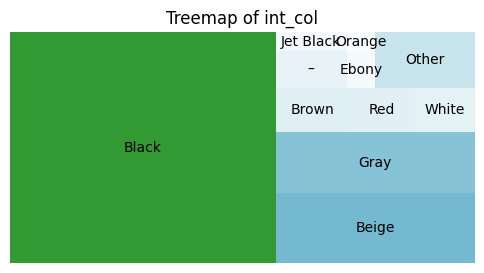

In [20]:
# Categorical Columns of high cardinality
for col in categorical_columns_high_cardinality:
    value_counts = cars_train_df[col].value_counts()
    top_n = 10
    top_values = value_counts.nlargest(top_n)
    other_values = value_counts.iloc[top_n:].sum()
    top_values['Other'] = other_values
    value_counts = top_values
    print(f"Frequency counts for {col}:")
    print(value_counts)
    
    plt.figure(figsize=(6, 3))
    squarify.plot(sizes=value_counts.values, label=value_counts.index, alpha=.8, color=plt.cm.ocean_r(value_counts.values / max(value_counts.values)))
    plt.title(f'Treemap of {col}')
    plt.axis('off')
    plt.show()

## Data exploration - Metrics and Dimensions relation with Price

### Binary Variables

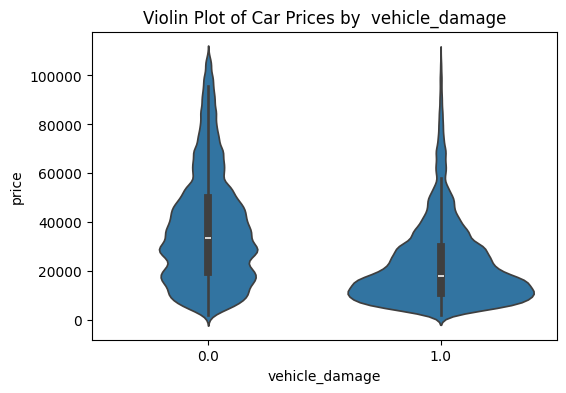

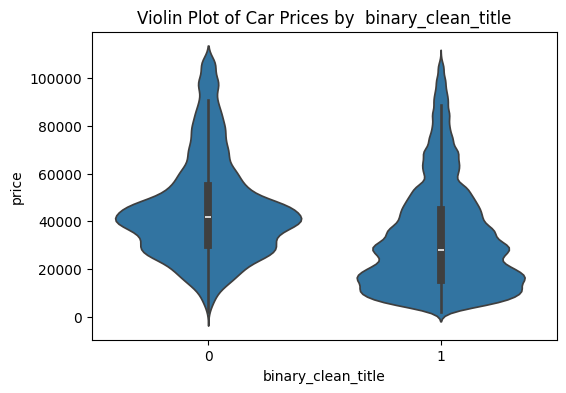

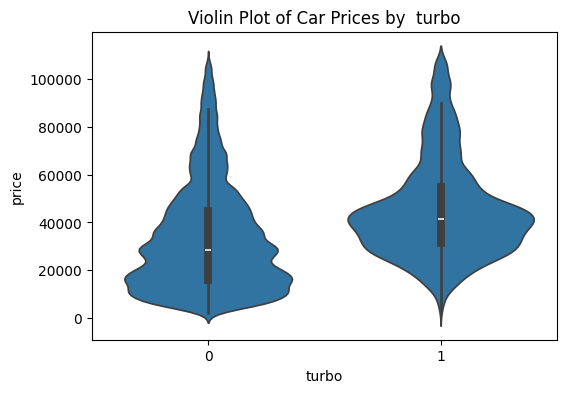

In [21]:
for col in binary_columns:
    # Set up the figure size
    plt.figure(figsize=(6, 4))
    
    # Create a violin plot for the 'price' column grouped by 'vehicle_damage'
    sns.violinplot(x=filtered_prices[col], y=filtered_prices['price'])
    
    # Disable scientific notation on the y-axis
    plt.ticklabel_format(style='plain', axis='y')
    
    # Add a title to the plot
    plt.title(f'Violin Plot of Car Prices by  {col}')
    
    # Show the plot
    plt.show()

### Numeric Columns

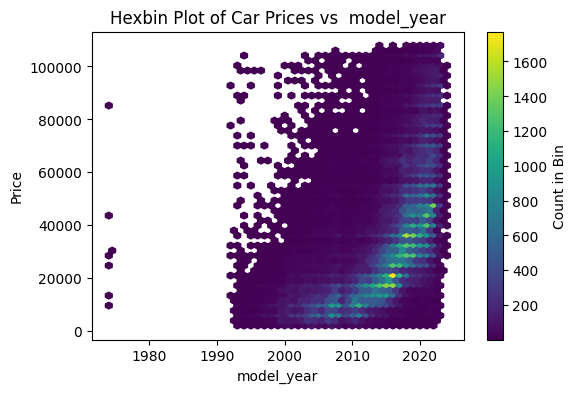

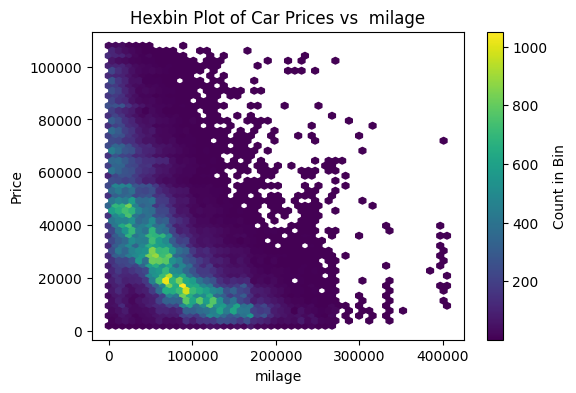

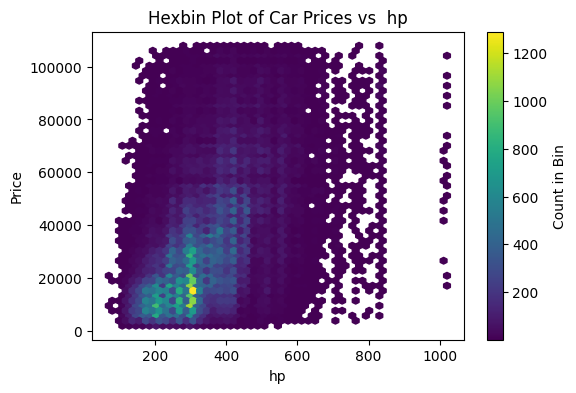

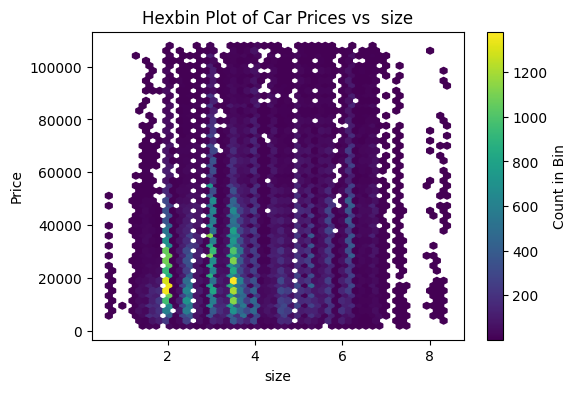

In [22]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    
    # Create a hexbin plot
    plt.hexbin(filtered_prices[col], filtered_prices['price'], gridsize=50, cmap='viridis', mincnt=1)
    
    # Add color bar to show the density
    plt.colorbar(label='Count in Bin')
    
    # Add title and labels
    plt.title(f'Hexbin Plot of Car Prices vs  {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Price')
    
    # Show the plot
    plt.show()

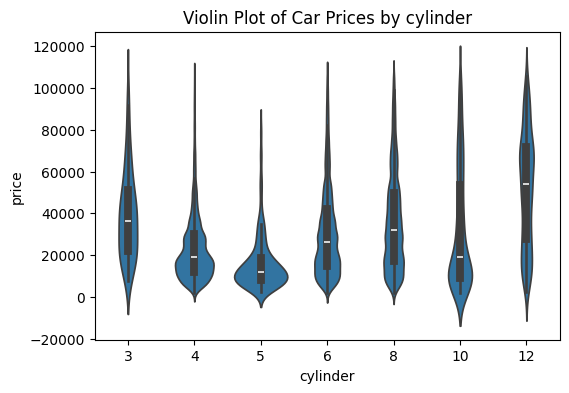

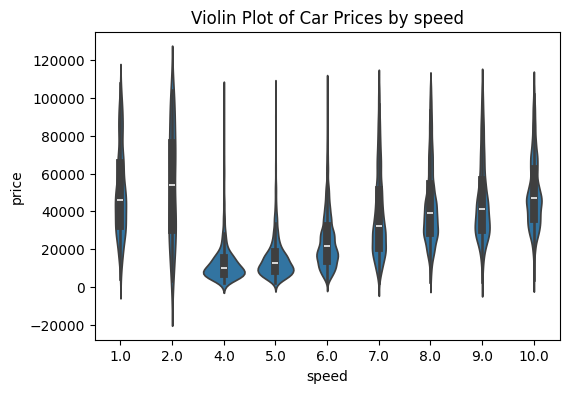

In [38]:
# Ordinal Columns
for col in ordinal_columns:
    # Set up the figure size
    plt.figure(figsize=(6, 4))
    
    # Sort the column values, excluding None/NaN and sorting numerically if possible
    sorted_order = sorted([x for x in filtered_prices[col].unique() if pd.notna(x)], key=lambda x: float(x))
    
    # Create a violin plot for the 'price' column grouped by the sorted 'col' values
    sns.violinplot(x=filtered_prices[col], y=filtered_prices['price'], order=sorted_order)
    
    # Disable scientific notation on the y-axis
    plt.ticklabel_format(style='plain', axis='y')
    
    # Add a title to the plot
    plt.title(f'Violin Plot of Car Prices by {col}')
    
    # Show the plot
    plt.show()

In [39]:
# There is not a positive relation between these ordinal variables and price, its better to treat this columns as categorical columns

#New Column Definitions

binary_columns = ['vehicle_damage', 'binary_clean_title','turbo']
categorical_columns_low_cardinality = ['fuel_type','fuel_type_2','engine_config', 'transmission_type','cylinder','speed']
categorical_columns_high_cardinality = ['brand', 'model', 'ext_col', 'int_col']
numeric_columns = ['model_year', 'milage','hp','size']

### Categorical Columns low cardinality

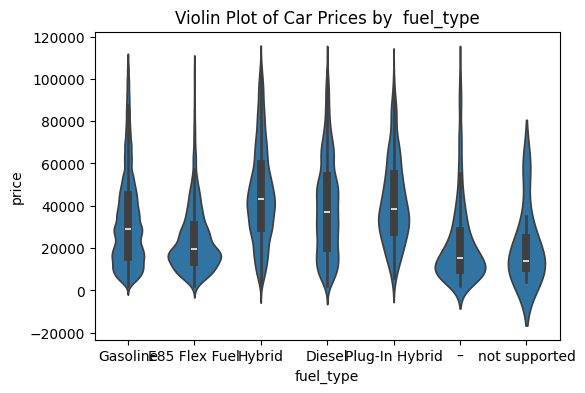

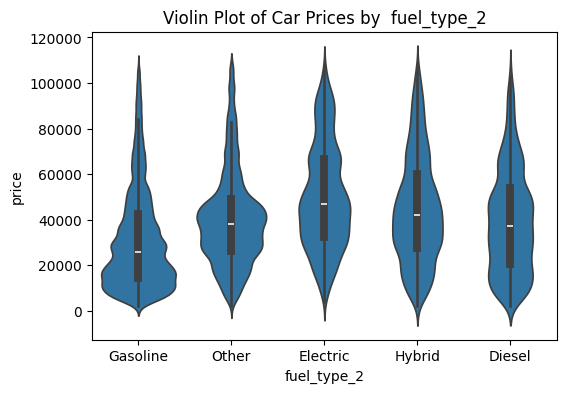

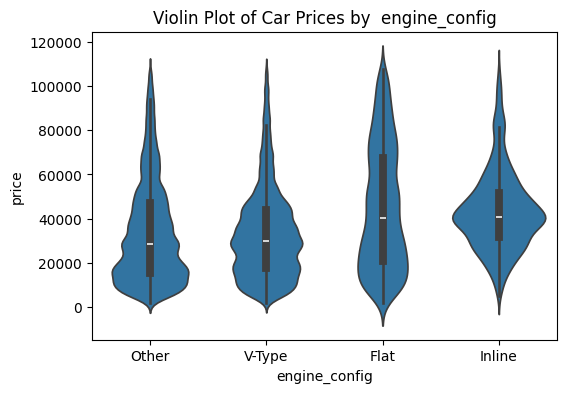

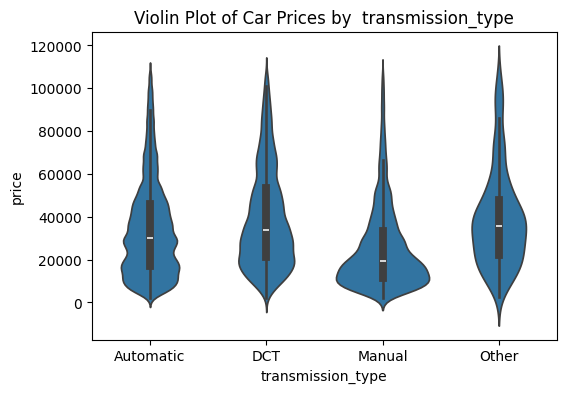

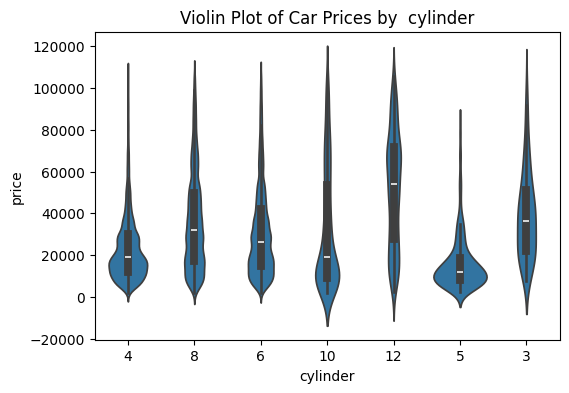

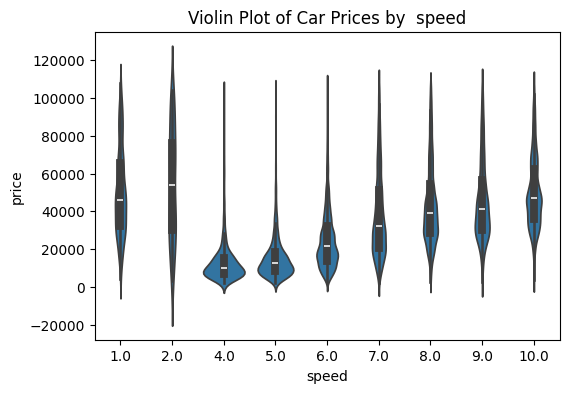

In [40]:
# Categorical Columns
for col in categorical_columns_low_cardinality:
    # Set up the figure size
    plt.figure(figsize=(6, 4))
    
    # Create a violin plot for the 'price' column grouped by 'vehicle_damage'
    sns.violinplot(x=filtered_prices[col], y=filtered_prices['price'])
    
    # Disable scientific notation on the y-axis
    plt.ticklabel_format(style='plain', axis='y')
    
    # Add a title to the plot
    plt.title(f'Violin Plot of Car Prices by  {col}')
    
    # Show the plot
    plt.show()

### Categorical Columns low cardinality

### Exterior color

In [25]:
# Average prices by exterior color
ext_color_avg_price = filtered_prices.groupby('ext_col')['price'].mean()

# Create 5 bins based on the average price
ext_col_price_bins = pd.qcut(ext_color_avg_price, 5, labels=[1, 2, 3, 4, 5])

# Map the bins back to the DataFrame
filtered_prices.loc[:,'ext_col_price_bin'] = filtered_prices['ext_col'].map(ext_col_price_bins)

# Check the distribution
print(filtered_prices['ext_col_price_bin'].value_counts())

ext_col_price_bin
1    136193
2     29004
3      6742
4      3936
5      3272
Name: count, dtype: int64


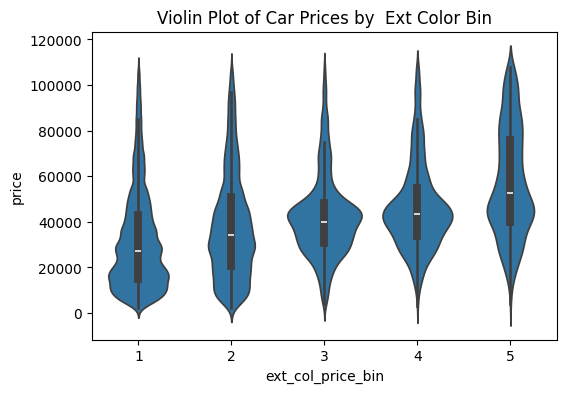

In [26]:
plt.figure(figsize=(6, 4))

# Create a violin plot for the 'price' column grouped by 'vehicle_damage'
sns.violinplot(x=filtered_prices['ext_col_price_bin'], y=filtered_prices['price'])

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Add a title to the plot
plt.title(f'Violin Plot of Car Prices by  Ext Color Bin')

# Show the plot
plt.show()

In [27]:
ext_col_price_bins

ext_col
Agate Black Metallic              4
Alfa White                        4
Alpine White                      5
Alta White                        4
Ametrin Metallic                  5
                                 ..
Yulong White                      4
designo Diamond White             4
designo Diamond White Bright      4
designo Diamond White Metallic    5
–                                 5
Name: price, Length: 319, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

#### Interior Color

In [31]:
# Average prices by exterior color
int_color_avg_price = filtered_prices.groupby('int_col')['price'].mean()

# Create 5 bins based on the average price
int_col_price_bins = pd.qcut(int_color_avg_price, 5, labels=[1, 2, 3, 4, 5])

# Map the bins back to the DataFrame
filtered_prices.loc[:,'int_col_price_bin'] = filtered_prices['int_col'].map(int_col_price_bins)

# Check the distribution
print(filtered_prices['int_col_price_bin'].value_counts())

int_col_price_bin
1    153418
3     13265
2      9371
4      1924
5      1169
Name: count, dtype: int64


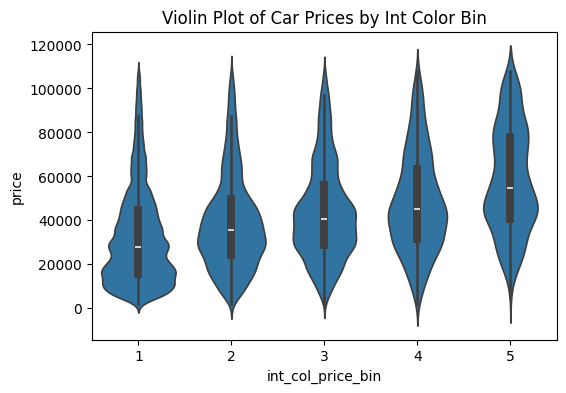

In [32]:
plt.figure(figsize=(6, 4))

# Create a violin plot for the 'price' column grouped by 'vehicle_damage'
sns.violinplot(x=filtered_prices['int_col_price_bin'], y=filtered_prices['price'])

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Add a title to the plot
plt.title(f'Violin Plot of Car Prices by Int Color Bin')

# Show the plot
plt.show()

In [33]:
int_col_price_bins

int_col
AMG Black         2
Adrenaline Red    5
Agave Green       5
Almond Beige      4
Amber             1
                 ..
Whisper Beige     1
White             3
White / Brown     1
Yellow            1
–                 1
Name: price, Length: 156, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

#### Brand

In [42]:
# Average prices by exterior color
brand_avg_price = filtered_prices.groupby('brand')['price'].mean()

# Create 5 bins based on the average price
brand_price_bins = pd.qcut(brand_avg_price, 5, labels=[1, 2, 3, 4, 5])

# Map the bins back to the DataFrame
filtered_prices.loc[:,'brand_price_bin'] = filtered_prices['brand'].map(brand_price_bins)

# Check the distribution
print(filtered_prices['brand_price_bin'].value_counts())

brand_price_bin
4    70954
3    56451
2    23667
5    15207
1    12868
Name: count, dtype: int64


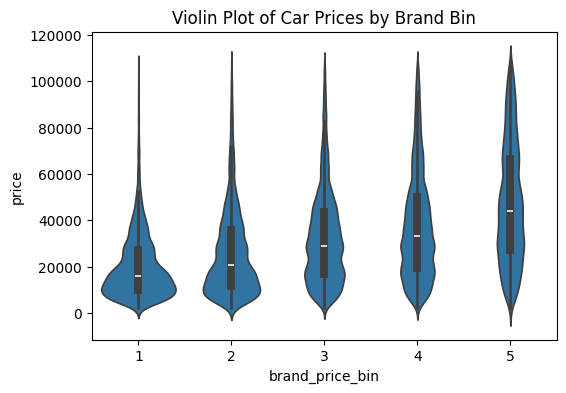

In [43]:
plt.figure(figsize=(6, 4))

# Create a violin plot for the 'price' column grouped by 'vehicle_damage'
sns.violinplot(x=filtered_prices['brand_price_bin'], y=filtered_prices['price'])

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Add a title to the plot
plt.title(f'Violin Plot of Car Prices by Brand Bin')

# Show the plot
plt.show()

In [44]:
brand_price_bins

brand
Acura            2
Alfa             4
Aston            5
Audi             3
BMW              4
Bentley          5
Bugatti          5
Buick            2
Cadillac         4
Chevrolet        4
Chrysler         1
Dodge            2
FIAT             2
Ferrari          5
Ford             3
GMC              3
Genesis          4
Honda            1
Hummer           1
Hyundai          1
INFINITI         3
Jaguar           4
Jeep             3
Karma            4
Kia              3
Lamborghini      5
Land             4
Lexus            3
Lincoln          2
Lotus            2
Lucid            5
MINI             1
Maserati         4
Maybach          5
Mazda            1
McLaren          5
Mercedes-Benz    4
Mercury          1
Mitsubishi       1
Nissan           2
Plymouth         2
Polestar         3
Pontiac          1
Porsche          5
RAM              4
Rivian           5
Rolls-Royce      5
Saab             3
Saturn           1
Scion            1
Subaru           1
Suzuki           3
Tesla 

In [75]:
# Create a DataFrame with the exterior color and its price bin
ext_color_bins_mapping = pd.DataFrame({
    'ext_col': ext_color_avg_price.index,
    'ext_col_price_bin': ext_col_price_bins.values
})

int_color_bins_mapping = pd.DataFrame({
    'int_col': int_color_avg_price.index,
    'int_col_price_bin': int_col_price_bins.values
})

brand_bins_mapping = pd.DataFrame({
    'brand': brand_avg_price.index,
    'brand_price_bin': brand_price_bins.values
})

In [76]:
# Save this mapping to a CSV file
ext_color_bins_mapping.to_csv('data/ext_color_bins_mapping.csv', index=False)
int_color_bins_mapping.to_csv('data/int_color_bins_mapping.csv', index=False)
brand_bins_mapping.to_csv('data/brand_bins_mapping.csv', index=False)

In [69]:
# Find the median bin
most_frequent_ext_color_bin  = ext_color_bins_mapping['ext_col_price_bin'].mode()[0]
most_frequent_int_color_bin  = int_color_bins_mapping['int_col_price_bin'].mode()[0]
most_frequent_brand_bin  = brand_bins_mapping['brand_price_bin'].mode()[0]

print("most_frequent_ext_color_bin: ",most_frequent_ext_color_bin)
print("most_frequent_int_color_bin: ",most_frequent_int_color_bin)
print("most_frequent_brand_bin: ",most_frequent_brand_bin)

most_frequent_ext_color_bin:  1
most_frequent_int_color_bin:  1
most_frequent_brand_bin:  1


In [71]:
 ext_color_bins_mapping['ext_col_price_bin'].value_counts()

ext_col_price_bin
1    64
2    64
4    64
5    64
3    63
Name: count, dtype: int64

In [72]:
 int_color_bins_mapping['int_col_price_bin'].value_counts()

int_col_price_bin
1    32
2    31
3    31
4    31
5    31
Name: count, dtype: int64

In [73]:
brand_bins_mapping['brand_price_bin'].value_counts()

brand_price_bin
1    12
5    12
2    11
3    11
4    11
Name: count, dtype: int64

In [26]:
cars_train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,binary_clean_title,hp,size,cylinder,fuel_type_2,engine_config,turbo,transmission_type,speed,color_price_bin
0,0,MINI,Cooper S Base,"2,007","213,000",Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,1,172,2,4,Gasoline,Other,0,Automatic,NaN,2
1,1,Lincoln,LS V8,"2,002","143,250",Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,1,252,4,8,Gasoline,Other,0,Automatic,NaN,1
2,2,Chevrolet,Silverado 2500 LT,"2,002","136,731",E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,1,320,5,8,Other,Other,0,Automatic,NaN,2
3,3,Genesis,G90 5.0 Ultimate,"2,017","19,500",Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,1,420,5,8,Gasoline,Other,0,DCT,NaN,2
4,4,Mercedes-Benz,Metris Base,"2,021","7,388",Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,1,208,2,4,Gasoline,Other,0,Automatic,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,"2,017","49,000",Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,...,1,420,6,8,Gasoline,Other,0,DCT,NaN,2
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,"2,018","28,600",Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,...,1,385,3,6,Gasoline,V-Type,0,Automatic,8,2
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,"2,021","13,650",Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,1,469,4,8,Gasoline,Other,0,Automatic,7,2
188531,188531,Audi,S5 3.0T Prestige,"2,022","13,895",Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,...,0,NaN,3,NaN,Other,Other,0,Automatic,1,5


In [38]:
numeric_columns = ['model_year', 'milage','hp','size']
ordinal_columns = ['cylinder','speed']

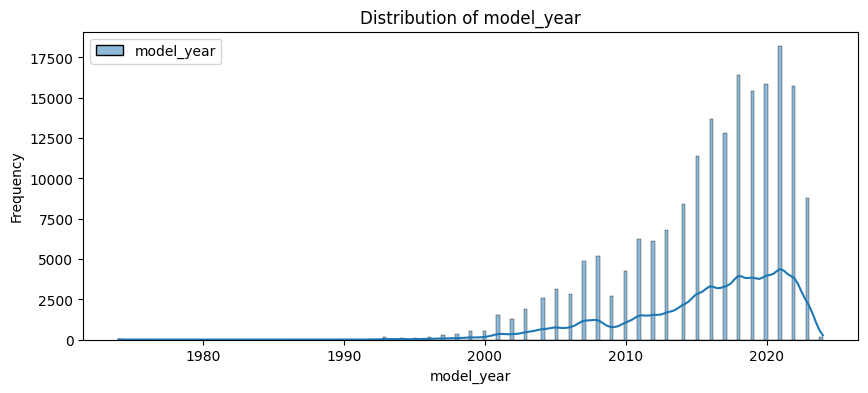

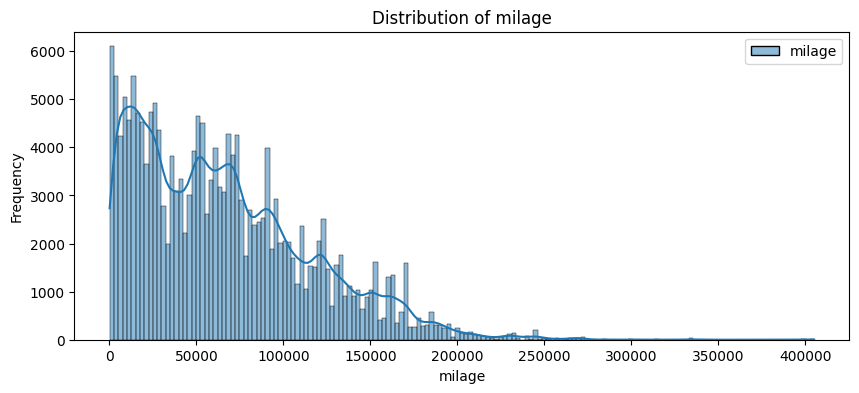

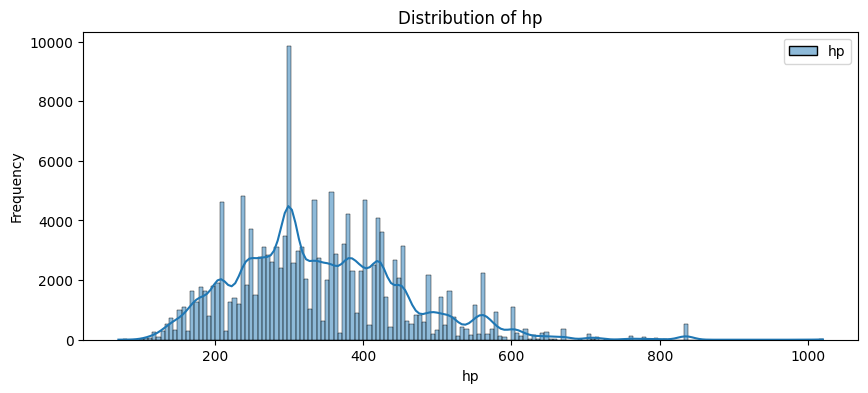

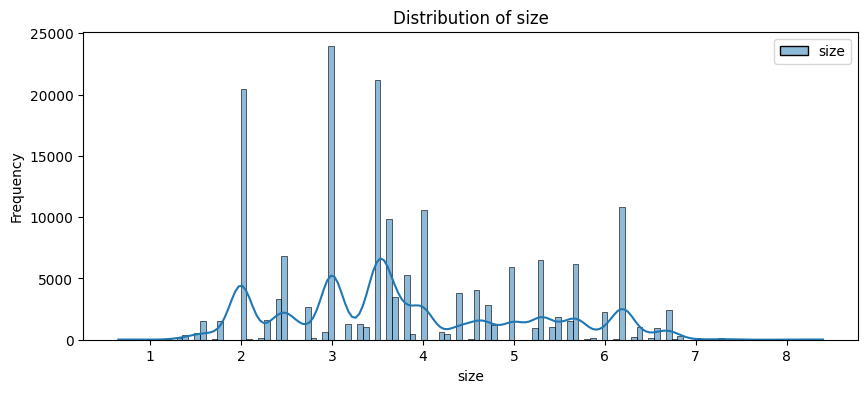

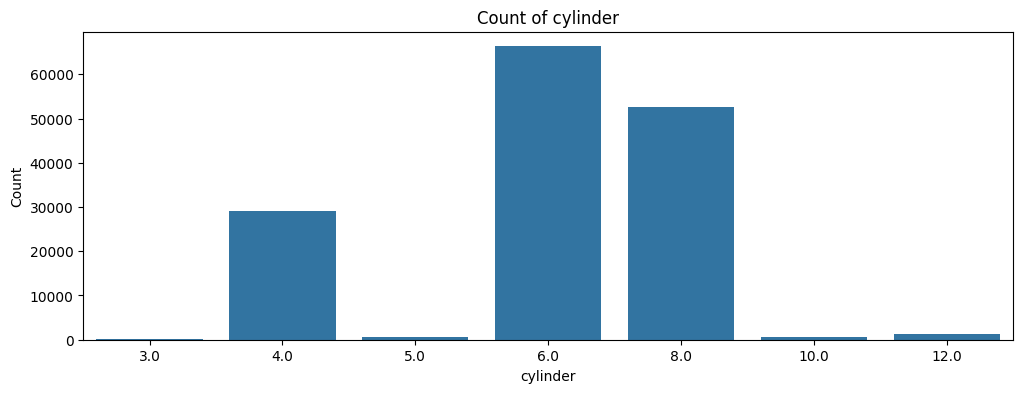

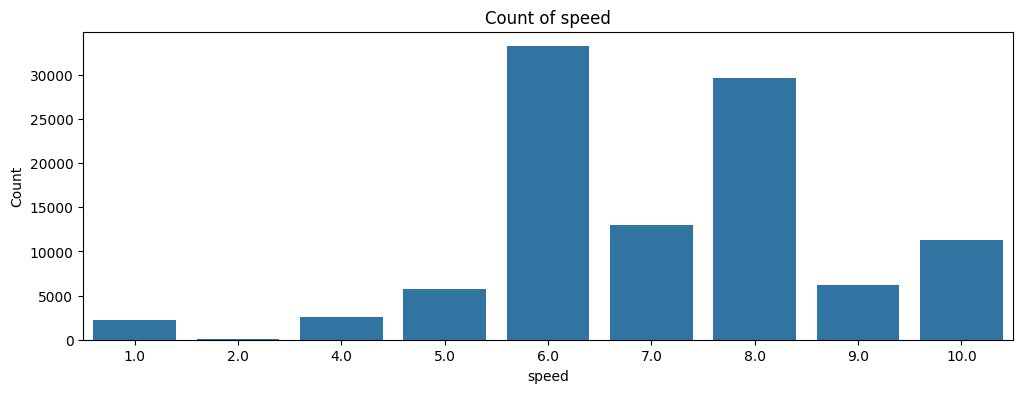

In [39]:

# Numeric data analysis
for col in numeric_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot([cars_train_df[col]], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Ordinal data analysis
for col in ordinal_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=cars_train_df[col])
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()